In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#! /usr/bin/env python
# -*- coding: UTF-8 -*-
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import datetime
date_string = datetime.datetime.now().strftime("%H:%M / %d-%m-%Y")

Using TensorFlow backend.


In [0]:
#Loading the dataset
def loadDataset():
    dataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/malayaDataset.data")
    return dataset
dataset =loadDataset()

In [0]:
#Separation of words.
input_sentences = [text.split(" ") for text in dataset["text"].values.tolist()]
labels = dataset["emotions"].values.tolist()

In [9]:
# Initialize word2id and label2id dictionaries that will be used to encode words and labels
word2id = dict()
label2id = dict()
max_words = 0 # maximum number of words in a sentence
# Construction of word2id dict
for sentence in input_sentences:
    for word in sentence: 
        # Add words to word2id dict if not exist.
        if word not in word2id:
            word2id[word] = len(word2id)
    # If length of the sentence is greater than max_words, update max_words
    if len(sentence) > max_words:
        max_words = len(sentence)   
        
# Construction of label2id and id2label dicts
label2id = {'love': 0, 'joy': 1, 'sadness': 2, 'anger': 3, 'surprise': 4, 'fear': 5} 
# Since the label sequence in the model is different from the code, the label sequence has been changed manually.
id2label = {v: k for k, v in label2id.items()}
print(label2id) # label sequence in code
f = open('labelDict.txt','a')
f.write(str(label2id)+'>>>'+date_string+'\n')
f.close()
#{'love': 0, 'joy': 1, 'sadness': 2, 'anger': 3, 'surprise': 4, 'fear': 5}>>>13:38 / 30-07-2019 server labelid

{'love': 0, 'joy': 1, 'sadness': 2, 'anger': 3, 'surprise': 4, 'fear': 5}


In [10]:
# Encode input words and labels
X = [[word2id[word] for word in sentence] for sentence in input_sentences]
Y = [label2id[label] for label in labels]
# Apply Padding to X
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, max_words)                                               #Dropout the maxword number to X.
Y = keras.utils.to_categorical(Y, num_classes=len(label2id), dtype='float32') #Convert Y to numpy array
# Print shapes
print("Shape of X: {}".format(X.shape))
print("Shape of Y: {}".format(Y.shape))

Shape of X: (416809, 178)
Shape of Y: (416809, 6)


In [11]:
embedding_dim = 100 # The dimension of word embeddings
# Define input tensor
sequence_input = keras.Input(shape=(max_words,), dtype='int32')
# Word embedding layer
embedded_inputs =keras.layers.Embedding(len(word2id) + 1,
                                        embedding_dim,
                                        input_length=max_words)(sequence_input)

# Apply dropout to prevent overfitting 
embedded_inputs = keras.layers.Dropout(0.2)(embedded_inputs)

# Apply Bidirectional LSTM over embedded inputs
lstm_outs = keras.layers.wrappers.Bidirectional(
    keras.layers.LSTM(embedding_dim, return_sequences=True)
)(embedded_inputs)

# Apply dropout to LSTM outputs to prevent overfitting
lstm_outs = keras.layers.Dropout(0.2)(lstm_outs)

# Attention Mechanism - Generate attention vectors
input_dim = int(lstm_outs.shape[2])
permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

# Last layer: fully connected with softmax activation
fc = keras.layers.Dense(embedding_dim, activation='relu')(attention_output)
output = keras.layers.Dense(len(label2id), activation='softmax')(fc)

# Finally building model
model = keras.Model(inputs=[sequence_input], outputs=output)
model.compile(loss="categorical_crossentropy", metrics=["acc"], optimizer='adam')

W0801 07:15:53.107026 140660946478976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 07:15:53.146996 140660946478976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 07:15:53.157653 140660946478976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0801 07:15:53.174526 140660946478976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0801 07:15:53.189766 

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.024391, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.025, random_state=1)
#In this way, train, val, test set will be 95%, 2.4%, 2.5% of the dataset respectively.
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape) 
print (X_test.shape, y_test.shape)
#history = model.fit(X, Y, epochs=2, batch_size=128, validation_data = (X_val, y_val), shuffle=False, verbose=1)

(396475, 178) (396475, 6)
(10167, 178) (10167, 6)
(10167, 178) (10167, 6)


In [13]:
from keras.models import load_model
model = load_model("/content/drive/My Drive/Colab Notebooks/TextEmotionLSTM-260719.h5") #server model epochs 30
scores= model.evaluate(X_val, y_val, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

W0801 07:16:14.934901 140660946478976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


10167/10167 [==============================] - 92s 9ms/step
acc: 94.13%


In [14]:
scores= model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

10167/10167 [==============================] - 91s 9ms/step
acc: 94.60%


In [0]:
def model_save():
        model.save('model/TextEmotionLSTM-3007(epch2).h5')
        hist_df = pd.DataFrame(history.history)
        model.save_weights('model/model_weights-3107(epch2).hdf5')
        # history save to csv:
        with open('model/history-3107(epch2).csv', mode='w') as f:
            hist_df.to_csv(f)
        return print('Model saved and history.')
#model_save()

In [15]:
#VAL CONFUSION MATRIX
model.reset_states()
y_pred = model.predict(X_test, batch_size=64)
yPred = [np.argmax(line) for line in y_pred]
yPred = np.array(yPred)[:, None]
yVal = [np.argmax(line) for line in  y_val]
yVal = np.array( yVal)[:, None]
cm = confusion_matrix( yVal, yPred)
acc = accuracy_score(yVal, yPred)
print('VAL CONFUSION MATRIX')
print(cm)
print('MODEL ACCURACY: ', acc)

VAL CONFUSION MATRIX
[[  94  260  227  109   18  109]
 [ 329 1103  977  503   85  474]
 [ 336  925  812  404   61  414]
 [ 151  444  427  182   32  158]
 [  52  109  107   46   15   48]
 [ 142  354  316  160   26  158]]
MODEL ACCURACY:  0.23251696665683091


<Figure size 432x288 with 0 Axes>

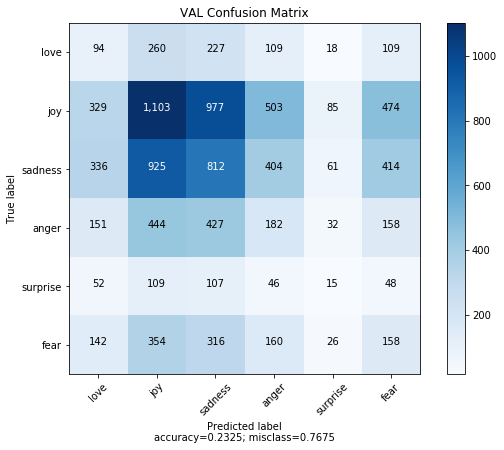

<Figure size 432x288 with 0 Axes>

In [17]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Val Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools
    fig = plt.figure()
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig("ValConfusionMatrix(3107).png")
plot_confusion_matrix(cm           = np.array(cm), 
                      normalize    = False,
                      target_names = ["love", "joy", "sadness", "anger", "surprise", "fear"], 
                      title        = "VAL Confusion Matrix")

In [18]:
#TEST CONFUSION MATRIX
model.reset_states()
y_pred = model.predict(X_test, batch_size=64)
yPred = [np.argmax(line) for line in y_pred]
yPred = np.array(yPred)[:, None]
yTest = [np.argmax(line) for line in y_test]
yTest = np.array(yTest)[:, None]
cm = confusion_matrix(yTest, yPred)
acc = accuracy_score(yTest, yPred)
print('TEST CONFUSION MATRIX')
print(cm)
print('MODEL ACCURACY: ', acc)

TEST CONFUSION MATRIX
[[ 858    0    0    0    0    0]
 [ 246 3160    0    0    0    0]
 [   0    0 2861   50    0   52]
 [   0    0    0 1354    0   57]
 [   0   35    5    0  232   99]
 [   0    0    0    0    5 1153]]
MODEL ACCURACY:  0.9460017704337562


<Figure size 432x288 with 0 Axes>

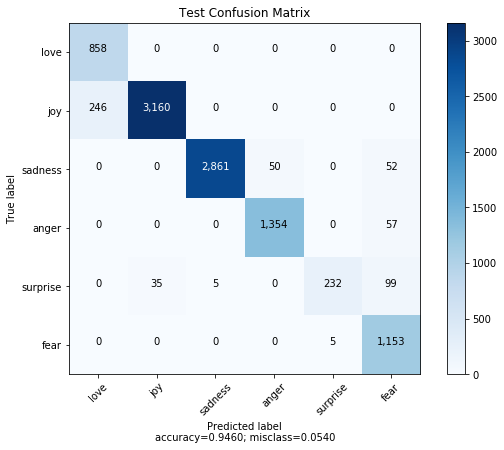

<Figure size 432x288 with 0 Axes>

In [19]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Test Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools
    fig = plt.figure()
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig("TestConfusionMatrix(3107).png")
plot_confusion_matrix(cm           = np.array(cm), 
                      normalize    = False,
                      target_names = ["love", "joy", "sadness", "anger", "surprise", "fear"],
                      title        = "Test Confusion Matrix")

In [0]:
# Re-create the model to get attention vectors as well as label prediction
model_with_attentions = keras.Model(inputs=model.input,
                                    outputs=[model.output, 
                                             model.get_layer('attention_vec').output])

In [0]:
import math
import re
try: 
    # enter text
    text = input("Enter text here:\n")
    sample_text =  (re.sub('[^A-Za-z]+', ' ', text)).lower().strip()

    # Encode samples
    tokenized_sample = sample_text.split(" ")
    encoded_samples = [[word2id[word] for word in tokenized_sample]]

    # Padding
    encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=max_words)

    # Make predictions
    label_probs, attentions = model_with_attentions.predict(encoded_samples)
    label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),(label_probs[0])*100)}
    print(label_probs)

    # Get word attentions using attenion vector
    token_attention_dic = {}
    max_score = 0.0
    min_score = 0.0
    for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
        token_attention_dic[token] = math.sqrt(attention_score)

    # VISUALIZATION
    import matplotlib.pyplot as plt; plt.rcdefaults()
    from IPython.core.display import display, HTML
    fig = plt.figure()
    def rgb_to_hex(rgb):
        return '#%02x%02x%02x' % rgb

    def attention2color(attention_score):
        r = 255 - int(attention_score * 255)
        color = rgb_to_hex((255, r, r))
        return str(color)

    # Build HTML String to viualize attentions
    html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
    for token, attention in token_attention_dic.items():
        html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                            token)
    html_text += "</p>"
    # Display text enriched with attention scores 
    display(HTML(html_text))
    # PLOT EMOTION SCORES
    emotions = [label for label, _ in label_probs.items()]
    scores = [score for _, score in label_probs.items()]
    plt.figure(figsize=(6,3))
    plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
    plt.xticks(np.arange(len(emotions)), emotions )
    plt.ylabel('Scores')
    plt.show()
    fig.savefig("Text Emotion score(3107).png")
    
    f = open('processedTextList.txt','a')
    f.write('\nText:'+ text + '\nLabel Score: '+ str(label_probs) + '\nTransaction Date: ' + date_string + '\n')
    f.close()
        
except KeyError:
    print("------------------------------------------")
    print("There are words I don't know in this text.")
    print("------------------------------------------")
    pass
    
"""
Now that Hopper has flown, Starship update probably in two weeks or so.

Tesla owners can schedule service appointments in under a minute just using their Tesla phone app!
Tesla Service Centers are being opened as fast as possible across Eastern Europe

I heard probably  shots Three people have been killed and at least  injured after a gunman attacked a food festival in California

Fifty years ago, humans took their first steps on the Moon. The world watched as we made history.  This week, you can
watch us salute our heroes and look forward to our next giant leap for future missions to the Moon and Mars. 

"""

In [23]:
from sklearn.metrics import classification_report
report = classification_report(yTest, yPred,target_names= emotions)
print(report)

              precision    recall  f1-score   support

        love       0.78      1.00      0.87       858
         joy       0.99      0.93      0.96      3406
     sadness       1.00      0.97      0.98      2963
       anger       0.96      0.96      0.96      1411
    surprise       0.98      0.63      0.76       371
        fear       0.85      1.00      0.92      1158

    accuracy                           0.95     10167
   macro avg       0.93      0.91      0.91     10167
weighted avg       0.95      0.95      0.95     10167

